In [1]:
import numpy as np
from neuralStellar2 import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import theano
import os
import pandas as pd
import matplotlib.pyplot as plt

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\Users\User\Anaconda3\lib\site-packages\theano\gpuarray\__init__.py", line 227, in <module>
    use(config.device)
  File "C:\Users\User\Anaconda3\lib\site-packages\theano\gpuarray\__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "C:\Users\User\Anaconda3\lib\site-packages\theano\gpuarray\__init__.py", line 99, in init_dev
    **args)
  File "pygpu\gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu\gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'Could not load "nvcuda.dll": The specified module could not be found.\r\n'
Using TensorFlow backend.


In [9]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'], Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_77/000_best_model.h5')

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_79 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_80 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_81 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_82 (Dense)             (None, 128)             

In [7]:
Tdata = np.load('pymc3_traces/NNcluster4/cluster_data.npy',allow_pickle=True)
[[Tmass,Tage,Tfeh,TY,TMLT],[TL,TTeff,Tdelnu]] = Tdata
N = len(Tmass)

In [26]:
model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*(0.5*2)+(3.6-0.5))
    Age_sigma = pm.Bound(pm.Lognormal, lower=0, upper=0.3)('spread_age', T.log(0.1), 0.1)
    Age = pm.Normal('age', Age_mu, Age_sigma, shape=N)
    #Age = pm.Deterministic('age',pm.Beta('b',1.5,1.5,shape=N)*2*Age_sigma+(Age_mu-Age_sigma))
    M = pm.Deterministic('mass', pm.Beta('d',1.1,1.1,shape=N)*(1.3-0.8)+0.8)
    feh = pm.Deterministic('feh', T.zeros(N))
    #Y_mu = pm.Bound(pm.Normal, lower=0.27, upper=0.29)('mean_Y', 0.28, 0.005)
    #Y_sigma = pm.Bound(pm.Lognormal, lower=0, upper=0.03)('spread_Y', T.log(0.01), 0.05)
    #Y = pm.Normal('Y', Y_mu, Y_sigma, shape=N)
    #Y = pm.Deterministic('Y',pm.Beta('d',1.5,1.5,shape=N)*2*Y_sigma+(Y_mu-Y_sigma))
    Y = pm.Deterministic('Y',T.ones(N)*0.28)
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    true_Teff = pm.Deterministic('true_Teff', 10**obs[1,:]*5000)
    true_L = pm.Deterministic('true_L', (10**obs[0,:])**2*(true_Teff/5776.02970722)**4)
    obs_L = pm.Normal('obs_L',true_L,0.1, observed=TL)
    obs_Teff = pm.Normal('obs_Teff',true_Teff,70, observed=TTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2,:],0.1, observed=Tdelnu)

In [27]:
trace = pm.load_trace(directory='pymc3_traces/NNcluster4', model=model)
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age[0],3.684,0.145,3.412,3.945,0.009,0.006,288.0,286.0,296.0,393.0,1.00
age[1],3.677,0.141,3.430,3.969,0.008,0.006,303.0,301.0,308.0,341.0,1.00
age[2],3.651,0.105,3.451,3.838,0.007,0.005,253.0,252.0,255.0,515.0,1.00
age[3],3.740,0.094,3.579,3.923,0.005,0.004,326.0,323.0,331.0,437.0,1.01
age[4],3.679,0.141,3.420,3.956,0.008,0.006,286.0,283.0,297.0,331.0,1.00
a,0.585,0.109,0.381,0.779,0.007,0.005,234.0,223.0,244.0,261.0,1.00
mean_age,3.685,0.109,3.481,3.879,0.007,0.005,234.0,232.0,244.0,261.0,1.00
spread_age,0.100,0.009,0.083,0.118,0.000,0.000,712.0,712.0,712.0,646.0,1.01
d[0],0.559,0.010,0.541,0.577,0.001,0.000,285.0,285.0,294.0,400.0,1.00
d[1],0.634,0.011,0.614,0.654,0.001,0.000,298.0,298.0,304.0,341.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF21ABFD68>,
      dtype=object)

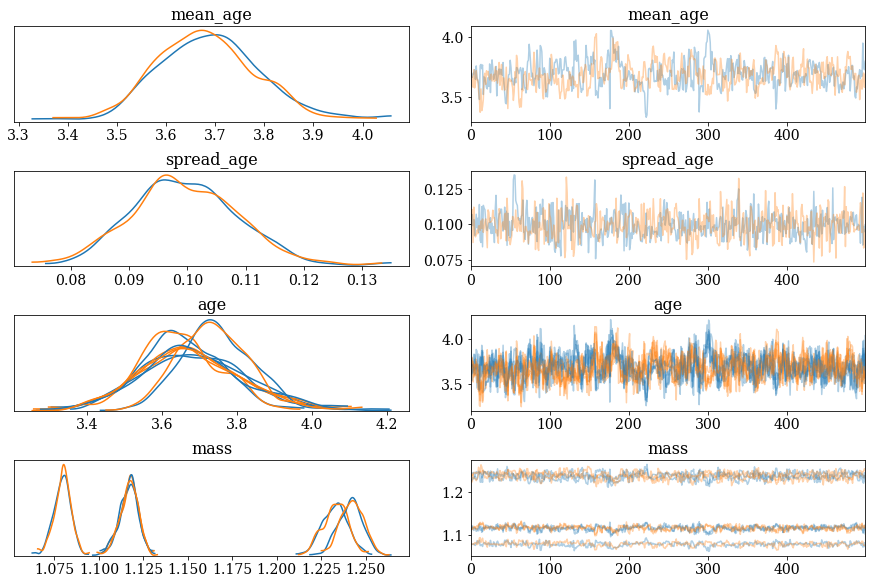

In [28]:
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','age','mass'],compact=True)

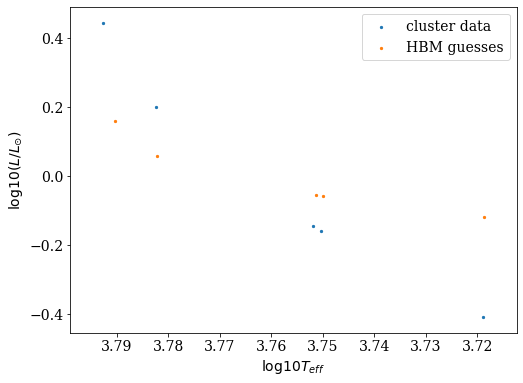

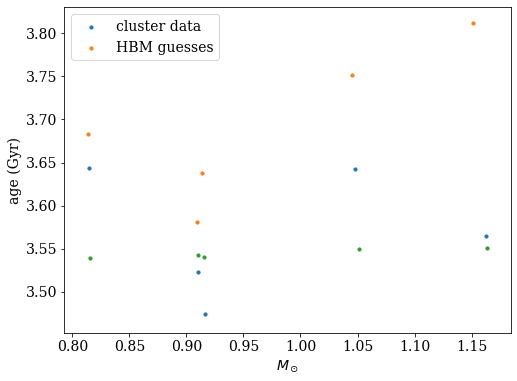

In [18]:
from matplotlib import rc
rc("font", family="serif", size=14)
pop1_ages=trace['age'][1]
pop1_masses = trace['mass'][1]
Finputs = np.log10(np.vstack((pop1_masses, pop1_ages, 10**Tfeh, TY, TMLT)))
Foutputs = m1.model.predict(Finputs.T).T
[FL, FTeff, Fdelnu] = 10**Foutputs
FTeff = FTeff*5000
fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(np.log10(TTeff), np.log10(TL), s=5, label='cluster data')
ax.scatter(np.log10(FTeff), np.log10(FL), s=5, label='HBM guesses')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(Tmass, Tage,s=10, label='cluster data')
ax.scatter(pop1_masses, pop1_ages, s=10, label='HBM guesses')
ax.scatter(np.mean(trace['mass'],axis=0), np.mean(trace['age'],axis=0),s=10)
ax.set_xlabel(r'$M_\odot$')
ax.set_ylabel(r'age (Gyr)')
ax.legend()
plt.show()

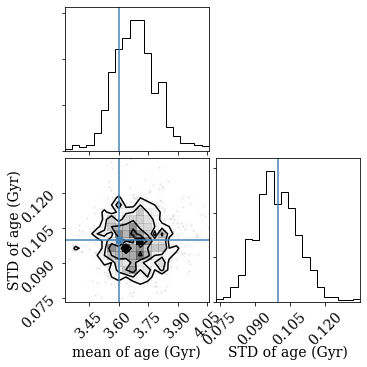

In [32]:
corner.corner(np.array([trace['mean_age'],trace['spread_age']]).T,
              #truths=[np.mean(Tage),np.std(Tage)],
              truths=[3.6,0.1],
              labels=['mean of age (Gyr)','STD of age (Gyr)'])
plt.show()